In [105]:
from typing import List, TypedDict, Literal
from pydantic import BaseModel, Field
import time

from langchain_community.document_loaders import PyPDFLoader
from langchain_community.vectorstores import FAISS
from langchain_openai import OpenAIEmbeddings, ChatOpenAI
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_core.documents import Document
from langchain_core.prompts import ChatPromptTemplate

from langgraph.graph import StateGraph, START, END
from dotenv import load_dotenv

load_dotenv()

True

In [106]:
docs = (
    PyPDFLoader("C:\\Users\\PMYLS\\Desktop\\Gen-AI\\LangGraph\\self_RAG\\documents\\Company_Policies.pdf").load()
    + PyPDFLoader("C:\\Users\\PMYLS\\Desktop\\Gen-AI\\LangGraph\\self_RAG\\documents\\Company_Profile.pdf").load()
    + PyPDFLoader("C:\\Users\\PMYLS\\Desktop\\Gen-AI\\LangGraph\\self_RAG\\documents\\Product_and_Pricing.pdf").load()
)

In [107]:
chunks = RecursiveCharacterTextSplitter(
    chunk_size=600, chunk_overlap=150
).split_documents(docs)

In [108]:
embeddings = OpenAIEmbeddings(model="text-embedding-3-large")
vector_store = FAISS.from_documents(chunks, embeddings)
retriever = vector_store.as_retriever(search_kwargs={"k": 4})

In [109]:
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

In [110]:
# --------------------------------------------------
# Graph State
# --------------------------------------------------
class State(TypedDict):
    question: str
    need_retrieval: bool

    docs: List[Document]

    answer: str

In [117]:
class RetrieveDecision(BaseModel):
    should_retrieve: bool = Field(
        ...,
        description="True if external documents are needed to answer reliably, else False."
    )

decide_retrieval_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You decide whether retrieval is needed.\n"
            "Return JSON that matches this schema:\n"
            "{{'should_retrieve': boolean}}\n\n"
            "Guidelines:\n"
            "- should_retrieve=True if answering requires specific facts, citations, or info likely not in the model.\n"
            "- should_retrieve=False for general explanations, definitions, or reasoning that doesn't need sources.\n"
            "- If unsure, choose True."
        ),
        ("human", "Question: {question}"),
    ]
)


# IMPORTANT: no `.content` for structured output
should_retrieve_llm = llm.with_structured_output(RetrieveDecision)

import json
import ast

def decide_retrieval(state: "State"):
    prompt = decide_retrieval_prompt.format_prompt(question=state["question"])
    response = llm.invoke(prompt)
    try:
        # Try JSON first
        return {"need_retrieval": json.loads(response.content)["should_retrieve"]}
    except json.JSONDecodeError:
        # Fallback to Python dict parsing
        decision = ast.literal_eval(response.content)
        return {"need_retrieval": decision["should_retrieve"]}

In [118]:
direct_generation_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "Answer the question using only your general knowledge.\n"
            "Do NOT assume access to external documents.\n"
            "If you are unsure or the answer requires specific sources, say:\n"
            "'I don't know based on my general knowledge.'"
        ),
        ("human", "{question}"),
    ]
)


def generate_direct(state: State):
    out = llm.invoke(
        direct_generation_prompt.format_messages(
            question=state["question"]
        )
    )
    return {
        "answer": out.content
    }

In [119]:
def retrieve(state: State):
    return {"docs": retriever.invoke(state["question"])}

In [120]:
def route_after_decide(state: State) -> Literal["generate_direct", "retrieve"]:
    if state["need_retrieval"]:
        return "retrieve"
    return "generate_direct"

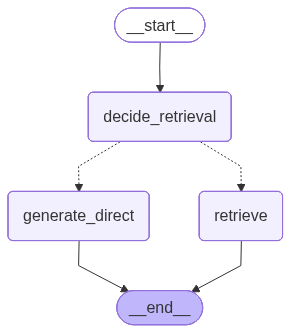

In [121]:
g = StateGraph(State)

g.add_node("decide_retrieval", decide_retrieval)
g.add_node("generate_direct", generate_direct)
g.add_node("retrieve", retrieve)

g.add_edge(START, "decide_retrieval")

g.add_conditional_edges(
    "decide_retrieval",
    route_after_decide,
    {
        "generate_direct":"generate_direct",
        "retrieve":"retrieve"
    }
)
g.add_edge("generate_direct", END)
g.add_edge("retrieve", END)

app = g.compile()
app

In [124]:
result = app.invoke({
    "question": "who is the CEO of Nexa AI",
    "is_retrieval_required": False,
    "docs":[],
    "answer":"",
    
})

print(result["answer"])

In [125]:
result['need_retrieval']

True